# Отток клиентов из банка

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет, на основании исторических данных о поведении клиентов и расторжении договоров с банком. 

Заказчик требует доведение метрики *F1* до 0.59. 
Дополнительно измеряется *AUC-ROC*, её значение сравнивается с *F1*-мерой.

Источник данных (данные немного изменены): [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

### Предварительное исследование данных

Загрузим библиотеки и методы, которые могут нам понадобиться. Согласно условию, модель должна определять, уйдет ли или не уйдет клиент, соответственно целевой признак - категориальный. Поэтому загрузим классификаторы.

In [1]:
import sklearn
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Назначим число зерном генератора псевдослучайных чисел, чтобы было легче ссылаться на него во всех моделях.

In [2]:
random = 12345

Загрузим файл и рассмотрим его.

In [3]:
df_raw = pd.read_csv('...')

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В данных присутствуют отсутствующие значения признака Tenure, в остальных признаках значения отсутствуют.  
Типы данных в целом подходят для работы, однако в том же признаке Tenure стоит заменить тип данных на целочисленный, а в HasCrCard, IsActiveMember и Exited - на булев.  
Также для удобства можно заменить регистр в наименованиях столбцов, чтобы впоследствии было легче обращаться к признакам.  
В первых 10 строках оказалось значение Surname H?. Несмотря на отсутствие пропусков в этом столбце, подобные значения в иных задачах пришлось бы обрабатывать каким-то образом. Однако в данном случае первые три столбца, выполняющие функции, по большому счету, идентификаторов строк и объектов, не будут участвовать в обучении модели и решении задачи, поэтому обрабатывать их смысла нет. 

Surname в набор обучающих данных не попадет, из категориальных мультиклассовых признаков будут Geography и Gender. Оценим количество классов в этих признаках.

In [5]:
df_raw['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [6]:
df_raw['Gender'].unique()

array(['Female', 'Male'], dtype=object)

Всего 3 класса признака Geography и 2 класса признака Gender. Это значит, что при применении метода ohe у нас не будет катастрофического прироста признаков.

### Наименования столбцов

Поменяем регистр, чтобы впредь было легче обращаться к названиям признаков.

In [7]:
df_raw.columns = df_raw.columns.str.lower()


### Обработка пропусков

Проверим, сколько пропусков в столбце Tenure.

In [8]:
len(df_raw[df_raw['tenure'].isna() == True])

909

Девятсот пропусков - это довольно много, почти 10% от выборки. Мы не можем удалить такое количество объектов, поэтому посмотрим, есть ли корреляция Tenure с каким-либо еще признаком и попробуем заполнить пропуски с его помощью. 

In [9]:
df_raw.corr()

,rownumber,customerid,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
rownumber,1.000000,0.004202,0.005840,0.000783,-0.007322,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
customerid,0.004202,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
creditscore,0.005840,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,0.000783,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
balance,-0.009067,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
numofproducts,0.007246,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
hascrcard,0.000599,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
isactivemember,0.012044,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimatedsalary,-0.005988,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


К сожалению, проследить какую-либо ощутимую зависимость между значениями tenure какими-то другими признаками не удается, ковариционная матрица показывает отсутствие сколь-нибудь сильной связи с каким-либо из признаков.  
Однако удалять 10% выборки из-за отсутствующего признака мы не будем. Заполним пропуски в этом столбце медианами в разбивке по hascrcard и isactivemember, которые по не очевидной причине имеют чуть более выраженную связь с tenure, чем остальные признаки.

In [10]:

pivot_salary = df_raw.pivot_table(
    index = 'hascrcard',
    columns = 'isactivemember',
    values = 'tenure', 
    aggfunc = 'median')

def tenure_filling1(row):
    card = row['hascrcard']
    active = row['isactivemember']
    tenure = row['tenure']
    try:
        return pivot_salary.loc[card, active]
    except:
        return tenure
    

df_raw.loc[df_raw['tenure'].isnull()==True, 'tenure'] = df_raw[df_raw['tenure'].isnull()==True].apply(tenure_filling1,axis=1)

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           10000 non-null  float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Обработка дубликатов

Проверим данные на наличие дубликатов. При проверке исключим столбцы, отвечающие за идентификацию строки, из-за которых строки независимо от того, одинаковые ли у них сочетания признаков, будут определены как уникальные.

In [11]:
df_raw.drop(['rownumber','customerid'], axis=1).duplicated().sum()

0

### Замена типов данных

Заменим в признаках hascrcard, isactivemember и exited тип данных на булевый. Также заменим тип данных в признаке tenure

In [12]:
df_raw.loc[:,['hascrcard', 'isactivemember', 'exited']] = df_raw.loc[:,['hascrcard', 'isactivemember', 'exited']].astype('bool')
df_raw['tenure'] = df_raw['tenure'].astype('int')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           10000 non-null  int32  
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  bool   
 11  isactivemember   10000 non-null  bool   
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  bool   
dtypes: bool(3), float64(2), int32(1), int64(5), object(3)
memory usage: 849.7+ KB


### Исключение столбцов. Масштабирование признаков

Перед тем, как примять технику прямого кодирования, избавимся от признаков, которые мы не будем использовать для обучения моделей, то есть первые три столбца.

In [13]:
df = df_raw.drop(['rownumber', 'customerid','surname'], axis = 1)

### Прямое кодирование категориальных признаков

Применим метод OHE. Он универсален и подойдет любому типу алгоритмов из тех, что мы будем использовать.  

In [14]:
df_ohe = pd.get_dummies(df, drop_first = True)
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   creditscore        10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   tenure             10000 non-null  int32  
 3   balance            10000 non-null  float64
 4   numofproducts      10000 non-null  int64  
 5   hascrcard          10000 non-null  bool   
 6   isactivemember     10000 non-null  bool   
 7   estimatedsalary    10000 non-null  float64
 8   exited             10000 non-null  bool   
 9   geography_Germany  10000 non-null  uint8  
 10  geography_Spain    10000 non-null  uint8  
 11  gender_Male        10000 non-null  uint8  
dtypes: bool(3), float64(2), int32(1), int64(3), uint8(3)
memory usage: 488.4 KB


### Порядковое кодирование категориальных признаков

Подготовим также данные, в которых применяется метод порядкового кодирования категориальных признаков. Он может пригодиться нам для обучения моделей с помощью дерева решений или случайного леса.   

In [15]:
ordin_encod=OrdinalEncoder()
ordin_encod.fit(df)
df_ordin = pd.DataFrame(ordin_encod.transform(df), columns = df.columns)
df_ordin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  float64
 1   geography        10000 non-null  float64
 2   gender           10000 non-null  float64
 3   age              10000 non-null  float64
 4   tenure           10000 non-null  float64
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  float64
 7   hascrcard        10000 non-null  float64
 8   isactivemember   10000 non-null  float64
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  float64
dtypes: float64(11)
memory usage: 859.5 KB


# 2. Исследование задачи

Исследуем распределение классов по общему количеству объектов.

In [16]:
df.query('exited == 1')['exited'].count()

2037

Объекты с положительным значением целевого признака составляют чуть более 20% от общего набора данных, присутствует значительный дисбаланс классов целевого признака.  

В целях исследования задачи обучим модели без учета дисбаланса классов и изучим получившиеся результаты.

In [17]:
ohe_features = df_ohe.drop('exited', axis = 1)
ohe_target = df_ohe['exited']
ohe_features_train, ohe_features_valid_test, ohe_target_train, ohe_target_valid_test = train_test_split(
    ohe_features, ohe_target, 
    test_size = 0.4, stratify = ohe_target,
    random_state = random) 
ohe_features_valid, ohe_features_test, ohe_target_valid, ohe_target_test = train_test_split(
    ohe_features_valid_test, ohe_target_valid_test, 
    test_size = 0.5, stratify = ohe_target_valid_test,
    random_state = random)

In [18]:
ordin_features = df_ordin.drop('exited', axis = 1)
ordin_target = df_ordin['exited']
ordin_features_train, ordin_features_valid_test, ordin_target_train, ordin_target_valid_test = train_test_split(
    ordin_features, ordin_target, 
    test_size = 0.3, stratify = ordin_target,
    random_state = random) 
ordin_features_valid, ordin_features_test, ordin_target_valid, ordin_target_test = train_test_split(
    ordin_features_valid_test, ordin_target_valid_test, 
    test_size = 0.5, stratify = ordin_target_valid_test,
    random_state = random)

In [19]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']
ohe_scaler = StandardScaler()
ohe_scaler.fit(ohe_features_train[numeric])
ohe_features_train[numeric] = ohe_scaler.transform(ohe_features_train[numeric])
ohe_features_valid[numeric] = ohe_scaler.transform(ohe_features_valid[numeric])
ohe_features_test[numeric] = ohe_scaler.transform(ohe_features_test[numeric])


D:\Tools\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Tools\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\Tools\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [20]:
ordin_scaler = StandardScaler()
ordin_scaler.fit(ordin_features_train[numeric])
ordin_features_train[numeric] = ordin_scaler.transform(ordin_features_train[numeric])
ordin_features_valid[numeric] = ordin_scaler.transform(ordin_features_valid[numeric])
ordin_features_test[numeric] = ordin_scaler.transform(ordin_features_test[numeric])


D:\Tools\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Tools\anaconda3\lib\site-packages\pandas\core\frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
D:\Tools\anaconda3\lib\site-packages\pandas\core\frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

### Дерево решений без учета дисбаланса

Проверим, какие результаты покажут модели, созданные на алогоритмах дерева решений и обученные на данных OHE, обработанных методом ohe и порядковым кодированием.

Проведем перебор сочетаний гиперпараметров для дерева решений, обученных на данных с OHE.

In [21]:
%%time

tree_depth_col = []
tree_min_leaf_col = []
tree_min_split_col = []
tree_acc_col = []
tree_f1_col = []
tree_recall_col = []
tree_precision_col = []
tree_roc_auc_col = []

for depth in range(2, 21, 2):
    for min_leaf in range(1, 10, 2):
        for min_split in range(2,10,2):
            model_tree_ohe = DecisionTreeClassifier(max_depth = depth, min_samples_split = min_split, min_samples_leaf = min_leaf, random_state = random)
            model_tree_ohe.fit(ohe_features_train, ohe_target_train)
            predicted_valid_tree_ohe = model_tree_ohe.predict(ohe_features_valid)
            acc_score_tree = accuracy_score(ohe_target_valid, predicted_valid_tree_ohe)
            f1_score_tree = f1_score(ohe_target_valid, predicted_valid_tree_ohe)
            recall_score_tree = recall_score(ohe_target_valid, predicted_valid_tree_ohe)
            precision_score_tree = precision_score(ohe_target_valid, predicted_valid_tree_ohe)
            probabilities_tree_ohe = model_tree_ohe.predict_proba(ohe_features_valid)
            probabilities_one_tree_ohe = probabilities_tree_ohe[:, 1]
            roc_auc_score_tree = roc_auc_score(ohe_target_valid, probabilities_one_tree_ohe)
            tree_depth_col.append(depth)
            tree_min_split_col.append(min_split)
            tree_min_leaf_col.append(min_leaf)
            tree_acc_col.append(acc_score_tree)
            tree_f1_col.append(f1_score_tree)
            tree_recall_col.append(recall_score_tree)
            tree_precision_col.append(precision_score_tree)
            tree_roc_auc_col.append(roc_auc_score_tree)
        
ohe_tree_hyperparameters_dict = {
    'max_depth': tree_depth_col, 
    'min_samples_split': tree_min_split_col, 
    'min_samples_leaf': tree_min_leaf_col, 
    'accuracy_score': tree_acc_col, 
    'recall_score': tree_recall_col,
    'precision_score': tree_precision_col, 
    'f1_score':tree_f1_col, 
    'roc_auc_score': tree_roc_auc_col}
ohe_tree_hyperparameters = pd.DataFrame(data = ohe_tree_hyperparameters_dict)
ohe_tree_hyperparameters

Wall time: 3.77 s


,max_depth,min_samples_split,min_samples_leaf,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
0,2,2,1,0.8350,0.438725,0.639286,0.520349,0.753960
1,2,4,1,0.8350,0.438725,0.639286,0.520349,0.753960
2,2,6,1,0.8350,0.438725,0.639286,0.520349,0.753960
3,2,8,1,0.8350,0.438725,0.639286,0.520349,0.753960
4,2,2,3,0.8350,0.438725,0.639286,0.520349,0.753960
...,...,...,...,...,...,...,...,...
195,20,8,7,0.8255,0.534314,0.578249,0.555414,0.771030
196,20,2,9,0.8330,0.507353,0.608824,0.553476,0.796636
197,20,4,9,0.8330,0.507353,0.608824,0.553476,0.796636
198,20,6,9,0.8330,0.507353,0.608824,0.553476,0.796636


Проведем перебор гипермараметров для дерева решений, обученного на данных с порядковым кодированием категориальных признаков. 

In [22]:
%%time

tree_depth_col = []
tree_min_leaf_col = []
tree_min_split_col = []
tree_acc_col = []
tree_f1_col = []
tree_recall_col = []
tree_precision_col = []
tree_roc_auc_col = []

for depth in range(2, 21, 2):
    for min_leaf in range(1, 10, 2):
        for min_split in range(2,10,2):
            model_tree_ordin = DecisionTreeClassifier(max_depth = depth, min_samples_split = min_split, min_samples_leaf = min_leaf, random_state = random)
            model_tree_ordin.fit(ordin_features_train, ordin_target_train)
            predicted_valid_tree_ordin = model_tree_ordin.predict(ordin_features_valid)
            acc_score_tree = accuracy_score(ordin_target_valid, predicted_valid_tree_ordin)
            f1_score_tree = f1_score(ordin_target_valid, predicted_valid_tree_ordin)
            recall_score_tree = recall_score(ordin_target_valid, predicted_valid_tree_ordin)
            precision_score_tree = precision_score(ordin_target_valid, predicted_valid_tree_ordin)
            probabilities_tree_ordin = model_tree_ordin.predict_proba(ordin_features_valid)
            probabilities_one_tree_ordin = probabilities_tree_ordin[:, 1]
            roc_auc_score_tree = roc_auc_score(ordin_target_valid, probabilities_one_tree_ordin)
            tree_depth_col.append(depth)
            tree_min_split_col.append(min_split)
            tree_min_leaf_col.append(min_leaf)
            tree_acc_col.append(acc_score_tree)
            tree_f1_col.append(f1_score_tree)
            tree_recall_col.append(recall_score_tree)
            tree_precision_col.append(precision_score_tree)
            tree_roc_auc_col.append(roc_auc_score_tree)
        
ordin_tree_hyperparameters_dict = {
    'max_depth': tree_depth_col, 
    'min_samples_split': tree_min_split_col, 
    'min_samples_leaf': tree_min_leaf_col, 
    'accuracy_score': tree_acc_col, 
    'recall_score': tree_recall_col,
    'precision_score': tree_precision_col, 
    'f1_score':tree_f1_col, 
    'roc_auc_score': tree_roc_auc_col}
ordin_tree_hyperparameters = pd.DataFrame(data = ordin_tree_hyperparameters_dict)
ordin_tree_hyperparameters

Wall time: 3.73 s


,max_depth,min_samples_split,min_samples_leaf,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
0,2,2,1,0.821333,0.421569,0.586364,0.490494,0.757428
1,2,4,1,0.821333,0.421569,0.586364,0.490494,0.757428
2,2,6,1,0.821333,0.421569,0.586364,0.490494,0.757428
3,2,8,1,0.821333,0.421569,0.586364,0.490494,0.757428
4,2,2,3,0.821333,0.421569,0.586364,0.490494,0.757428
...,...,...,...,...,...,...,...,...
195,20,8,7,0.824667,0.483660,0.584980,0.529517,0.770523
196,20,2,9,0.834000,0.483660,0.619247,0.543119,0.771299
197,20,4,9,0.834000,0.483660,0.619247,0.543119,0.771299
198,20,6,9,0.834000,0.483660,0.619247,0.543119,0.771299


Выведем строки с максимальным значением f1.

In [23]:
ordin_tree_hyperparameters.query('f1_score == f1_score.max()')

,max_depth,min_samples_split,min_samples_leaf,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
116,12,2,9,0.834,0.486928,0.618257,0.54479,0.779291
117,12,4,9,0.834,0.486928,0.618257,0.54479,0.779291
118,12,6,9,0.834,0.486928,0.618257,0.54479,0.779291
119,12,8,9,0.834,0.486928,0.618257,0.54479,0.779291


In [24]:
ohe_tree_hyperparameters.query('f1_score == f1_score.max()')

,max_depth,min_samples_split,min_samples_leaf,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
52,6,2,7,0.8625,0.480392,0.756757,0.587706,0.842704
53,6,4,7,0.8625,0.480392,0.756757,0.587706,0.842704
54,6,6,7,0.8625,0.480392,0.756757,0.587706,0.842704
55,6,8,7,0.8625,0.480392,0.756757,0.587706,0.842704


Максимальное значение f1 у модели, обученной на данных с прямым кодированием категориальных признаков. Это довольно интересно, учитывая, что порядковое кодирование лучше подходят для деревьев решений и случайного леса.

В любом случае, значения f1 дерева решений слишком низкие, на тестовой это значение с большой вероятностью упадет.

In [25]:
ohe_tree_hyperparameters['roc_auc_score'].mean()

0.7855929271048885

In [26]:
ohe_tree_hyperparameters['roc_auc_score'].median()

0.7850827359838407

In [27]:
ordin_tree_hyperparameters['roc_auc_score'].mean()

0.7790201278724789

In [28]:
ordin_tree_hyperparameters['roc_auc_score'].median()

0.7712993069924787

Примечательно, что несмотря на неудовлетворительный результат метрики f1, показатель площади под кривой ROC довольно высокий и у алгоритмов, использующих данные, обработанные методом OHE, и у алгоритмов на данных с порядковым кодированием признаков. У алгоритмов с данными OHE показатель ROC-AUC выше, хотя и несильно, больше эта разница заметна на моделях с лучшим показателем f1. У лучшей модели деревьев кривая выглядит следующим образом:

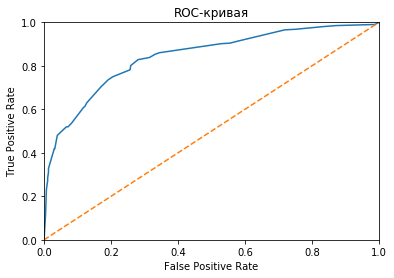

In [29]:
best_tree_depth = int(ohe_tree_hyperparameters.query('f1_score == f1_score.max()')['max_depth'].head(1))
best_tree_split = int(ohe_tree_hyperparameters.query('f1_score == f1_score.max()')['min_samples_split'].head(1))
best_tree_leaf = int(ohe_tree_hyperparameters.query('f1_score == f1_score.max()')['min_samples_leaf'].head(1))


best_tree_model = DecisionTreeClassifier(
    max_depth = best_tree_depth, 
    min_samples_split = best_tree_split, 
    min_samples_leaf = best_tree_leaf,
    random_state = random)
best_tree_model.fit(ohe_features_train, ohe_target_train)
probabilities_tree_valid = best_tree_model.predict_proba(ohe_features_valid)
probabilities_one_tree_valid = probabilities_tree_valid[:, 1]

fpr, tpr, thresholds = roc_curve(ohe_target_valid, probabilities_one_tree_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### Случайный лес без учета дисбаланса

Случайный лес обычно дает более точные предсказания, хотя он дольше работает, поэтому на перебор сочетаний гипермпараметров уйдет больше времени, даже несмотря на то, что мы перебираем не все подряд гиперпараметры. 

Проверим, какую точность даст случайный лес, обученный на данных OHE:

In [30]:
%%time

forest_depth_col = []
forest_estim_col = []
forest_min_leaf_col = []
forest_min_split_col = []
forest_score_col = []
forest_f1_col = []
forest_recall_col = []
forest_precision_col = []
forest_roc_auc_col = []

for depth in range(6,16,2):
    for min_leaf in range(1, 6, 2):
        for min_split in range(2,8,2):
            for estim in range(20, 110, 10):
                model_forest_ohe = RandomForestClassifier(n_estimators = estim, max_depth = depth, min_samples_split = min_split, min_samples_leaf = min_leaf, random_state = random)
                model_forest_ohe.fit(ohe_features_train, ohe_target_train)
                predicted_valid_forest_ohe = model_forest_ohe.predict(ohe_features_valid)
                score_forest = model_forest_ohe.score(ohe_features_valid, ohe_target_valid)
                recall_score_forest = recall_score(ohe_target_valid, predicted_valid_forest_ohe)
                precision_score_forest = precision_score(ohe_target_valid, predicted_valid_forest_ohe)
                probabilities_forest_ohe = model_forest_ohe.predict_proba(ohe_features_valid)
                probabilities_one_forest_ohe = probabilities_forest_ohe[:, 1]
                roc_auc_score_forest = roc_auc_score(ohe_target_valid, probabilities_one_forest_ohe)
                f1_forest = f1_score(ohe_target_valid, predicted_valid_forest_ohe)
                forest_depth_col.append(depth)
                forest_min_leaf_col.append(min_leaf)
                forest_min_split_col.append(min_split)
                forest_estim_col.append(estim)
                forest_score_col.append(score_forest)
                forest_recall_col.append(recall_score_forest)
                forest_precision_col.append(precision_score_forest)
                forest_f1_col.append(f1_forest)
                forest_roc_auc_col.append(roc_auc_score_forest)
        
        
ohe_forest_hyperparameters_dict = {
    'max_depth': forest_depth_col, 
    'n_estimators': forest_estim_col, 
    'min_samples_split': forest_min_split_col, 
    'min_samples_leaf': forest_min_leaf_col, 
    'score': forest_score_col,
    'recall_score': forest_recall_col,
    'precision_score': forest_precision_col,
    'f1_score': forest_f1_col, 
    'roc_auc_score': forest_roc_auc_col}
ohe_forest_hyperparameters = pd.DataFrame(data = ohe_forest_hyperparameters_dict)
ohe_forest_hyperparameters

Wall time: 1min 40s


,max_depth,n_estimators,min_samples_split,min_samples_leaf,score,recall_score,precision_score,f1_score,roc_auc_score
0,6,20,2,1,0.8590,0.416667,0.794393,0.546624,0.864617
1,6,30,2,1,0.8590,0.414216,0.797170,0.545161,0.869144
2,6,40,2,1,0.8590,0.409314,0.802885,0.542208,0.871101
3,6,50,2,1,0.8580,0.409314,0.795238,0.540453,0.870209
4,6,60,2,1,0.8565,0.394608,0.800995,0.528736,0.870476
...,...,...,...,...,...,...,...,...,...
400,14,60,6,5,0.8635,0.475490,0.766798,0.586989,0.873080
401,14,70,6,5,0.8640,0.473039,0.772000,0.586626,0.873935
402,14,80,6,5,0.8650,0.473039,0.778226,0.588415,0.874472
403,14,90,6,5,0.8650,0.473039,0.778226,0.588415,0.874383


Посмотрим, какие результаты выдаст случайный лес на основе данных, обработанных с помощью порядкового кодирования:

In [31]:
%%time

forest_depth_col = []
forest_estim_col = []
forest_min_leaf_col = []
forest_min_split_col = []
forest_score_col = []
forest_f1_col = []
forest_recall_col = []
forest_precision_col = []
forest_roc_auc_col = []

for depth in range(6,16,2):
    for min_leaf in range(1, 6, 2):
        for min_split in range(2,8,2):
            for estim in range(20, 110, 10):
                model_forest_ordin = RandomForestClassifier(n_estimators = estim, max_depth = depth, min_samples_split = min_split, min_samples_leaf = min_leaf, random_state = random)
                model_forest_ordin.fit(ordin_features_train, ordin_target_train)
                predicted_valid_forest_ordin = model_forest_ordin.predict(ordin_features_valid)
                score_forest = model_forest_ordin.score(ordin_features_valid, ordin_target_valid)
                recall_score_forest = recall_score(ordin_target_valid, predicted_valid_forest_ordin)
                precision_score_forest = precision_score(ordin_target_valid, predicted_valid_forest_ordin)
                probabilities_forest_ordin = model_forest_ordin.predict_proba(ordin_features_valid)
                probabilities_one_forest_ordin = probabilities_forest_ordin[:, 1]
                roc_auc_score_forest = roc_auc_score(ordin_target_valid, probabilities_one_forest_ordin)
                f1_forest = f1_score(ordin_target_valid, predicted_valid_forest_ordin)
                forest_depth_col.append(depth)
                forest_min_leaf_col.append(min_leaf)
                forest_min_split_col.append(min_split)
                forest_estim_col.append(estim)
                forest_score_col.append(score_forest)
                forest_recall_col.append(recall_score_forest)
                forest_precision_col.append(precision_score_forest)
                forest_f1_col.append(f1_forest)
                forest_roc_auc_col.append(roc_auc_score_forest)
        
        
ordin_forest_hyperparameters_dict = {
    'max_depth': forest_depth_col, 
    'n_estimators': forest_estim_col, 
    'min_samples_split': forest_min_split_col, 
    'min_samples_leaf': forest_min_leaf_col, 
    'score': forest_score_col,
    'recall_score': forest_recall_col,
    'precision_score': forest_precision_col,
    'f1_score': forest_f1_col, 
    'roc_auc_score': forest_roc_auc_col}
ordin_forest_hyperparameters = pd.DataFrame(data = ordin_forest_hyperparameters_dict)
ordin_forest_hyperparameters

Wall time: 1min 53s


,max_depth,n_estimators,min_samples_split,min_samples_leaf,score,recall_score,precision_score,f1_score,roc_auc_score
0,6,20,2,1,0.855333,0.372549,0.820144,0.512360,0.864051
1,6,30,2,1,0.853333,0.372549,0.802817,0.508929,0.863599
2,6,40,2,1,0.854667,0.379085,0.805556,0.515556,0.865523
3,6,50,2,1,0.854667,0.385621,0.797297,0.519824,0.864724
4,6,60,2,1,0.854000,0.382353,0.795918,0.516556,0.864246
...,...,...,...,...,...,...,...,...,...
400,14,60,6,5,0.862000,0.418301,0.815287,0.552916,0.862898
401,14,70,6,5,0.862667,0.415033,0.824675,0.552174,0.864130
402,14,80,6,5,0.862000,0.411765,0.823529,0.549020,0.864976
403,14,90,6,5,0.860667,0.408497,0.816993,0.544662,0.865600


In [32]:
best_ordin_forest = ordin_forest_hyperparameters.query('f1_score == f1_score.max()')
best_ordin_forest

,max_depth,n_estimators,min_samples_split,min_samples_leaf,score,recall_score,precision_score,f1_score,roc_auc_score
324,14,20,2,1,0.862,0.444444,0.786127,0.56785,0.85167


In [33]:
best_ohe_forest = ohe_forest_hyperparameters.query('f1_score == f1_score.max()')
best_ohe_forest

,max_depth,n_estimators,min_samples_split,min_samples_leaf,score,recall_score,precision_score,f1_score,roc_auc_score
351,14,20,2,3,0.8725,0.514706,0.786517,0.622222,0.865266
360,14,20,4,3,0.8725,0.514706,0.786517,0.622222,0.865266
369,14,20,6,3,0.8725,0.514706,0.786517,0.622222,0.865266


In [34]:
best_ordin_forest_depth = int(best_ordin_forest['max_depth'].head(1))
best_ordin_forest_n_estimators = int(best_ordin_forest['n_estimators'].head(1))
best_ordin_forest_split = int(best_ordin_forest['min_samples_split'].head(1))
best_ordin_forest_leaf = int(best_ordin_forest['min_samples_leaf'].head(1))

best_ohe_forest_depth = int(best_ohe_forest['max_depth'].head(1))
best_ohe_forest_n_estimators = int(best_ohe_forest['n_estimators'].head(1))
best_ohe_forest_split = int(best_ohe_forest['min_samples_split'].head(1))
best_ohe_forest_leaf = int(best_ohe_forest['min_samples_leaf'].head(1))


Значение f1 метрики составляет более 62 сотых, превышяя пороговое. Примечательно, что, несмотря на то, что техника порядкового кодирования категориальных признаков вроде как должна демонстрировать лучшие результаты при использовании алгоритмов дерева решений или случайного леса, лучший результат получен на основе данных, обработанных с помощью прямого кодирования.

Проверим, какое значение получится на тестовой выборке. Обучим модель на основе алогоритма с гиперпараметрами, при которых получилось наибольшее значение f1-метрики. Заодно сразу вызовем матрицу ошибок.

In [35]:
best_ordin_forest_model = RandomForestClassifier(
    max_depth = best_ordin_forest_depth, 
    n_estimators = best_ordin_forest_n_estimators, 
    min_samples_split = best_ordin_forest_split, 
    min_samples_leaf = best_ordin_forest_leaf, 
    random_state = random)
best_ordin_forest_model.fit(ordin_features_train, ordin_target_train)
best_ordin_predicted_valid = best_ordin_forest_model.predict(ordin_features_valid)
confusion_matrix(ordin_target_valid, best_ordin_predicted_valid)

array([[1157,   37],
       [ 170,  136]], dtype=int64)

In [36]:
best_ohe_forest_model = RandomForestClassifier(
    max_depth = best_ohe_forest_depth, 
    n_estimators = best_ohe_forest_n_estimators, 
    min_samples_split = best_ohe_forest_split, 
    min_samples_leaf = best_ohe_forest_leaf, 
    random_state = random)
best_ohe_forest_model.fit(ohe_features_train, ohe_target_train)
best_ohe_predicted_valid = best_ohe_forest_model.predict(ohe_features_valid)
confusion_matrix(ohe_target_valid, best_ohe_predicted_valid)

array([[1535,   57],
       [ 198,  210]], dtype=int64)

Обратимся к вызванным нами матрицам ошибок: из них можно заметить, что во всех случаях ошибок первого рода не так много, в то время как ложноотрицательных значений заметно больше, и по количеству они сопоставимы с истинно положительными.  
Можно также наблюдать, что понижение качества предсказания в случае с OHE обусловленно в первую очередь перераспределением результатов от истинно положительных к ложноотрицательным. То есть ухудшение качество происходит из-за того, что склонна не замечать положительные ответы и с изменением набора признаков эта склонность усугубляется.  
Все это позволяет нам определить, что основной потенциал улучшения качества - в улучшении способности модели определять положительные значения.

Посмотрим на показатель площади под кривой ROC.

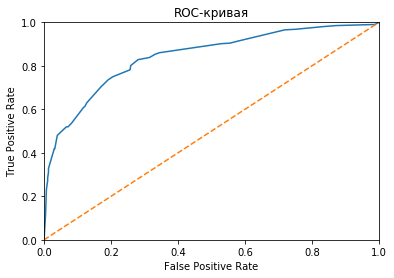

In [37]:
probabilities_forest_valid = best_ohe_forest_model.predict_proba(ohe_features_valid)
probabilities_one_forest_valid = probabilities_tree_valid[:, 1]

fpr, tpr, thresholds = roc_curve(ohe_target_valid, probabilities_one_forest_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [38]:
roc_auc_score(ohe_target_valid, probabilities_one_forest_valid)

0.8427038686077446

In [39]:
print('ohe')
print(ohe_forest_hyperparameters['roc_auc_score'].mean())
print(ohe_forest_hyperparameters['roc_auc_score'].median())
print()
print('ordin')
print(ordin_forest_hyperparameters['roc_auc_score'].mean())
print(ordin_forest_hyperparameters['roc_auc_score'].median())

ohe
0.8703326568390252
0.8706353458468814

ordin
0.8649259537689535
0.8651974469296373


В целом, как и в случае с деревьями решений, при не очень высоких значениях f1 значения roc-auc весьма высоки. 

### Логистическая регрессия без учета дисбаланса

Построим логистическую регрессию. Данные, обработанные порядковым кодированием, применять не будем.

In [40]:
model_reg = LogisticRegression(solver = 'liblinear')
model_reg.fit(ohe_features_train, ohe_target_train)
predicted_valid_reg = model_reg.predict(ohe_features_valid)
f1_score(ohe_target_valid, predicted_valid_reg)

0.3076923076923077

Результат заметно ниже, чем у других алгоритмов.

### Выводы

Потенциал для увеличения качества модели - в борьбе с дисбалансом. Лучшие результаты продемонстировал случайный лес на основе данных, обработанных OHE.

# 3. Борьба с дисбалансом

Применим методы борьбы с дисбалансом классов. Случайный лес, обученный на данных, обработанных с помощью прямого кодирования, продемонстрировал лучший результат. Сосредоточимся на нем.

### Взвешивание классов

Попробуем побороть дисбаланс, используя возможности RandomForestClassifier, а именно аргумент class_weight.

In [41]:
best_ohe_forest_model_balanced = RandomForestClassifier(
    max_depth = best_ohe_forest_depth, 
    n_estimators = best_ohe_forest_n_estimators, 
    min_samples_split = best_ohe_forest_split, 
    min_samples_leaf = best_ohe_forest_leaf, 
    random_state = random, class_weight = 'balanced')
best_ohe_forest_model_balanced.fit(ohe_features_train, ohe_target_train)
best_ohe_predicted_valid_balanced = best_ohe_forest_model_balanced.predict(ohe_features_valid)
f1_score(ohe_target_valid, best_ohe_predicted_valid_balanced)

0.6227848101265823

На всякий случай проверим, как с указанием этого агумента сработает логистическая регрессия:

In [42]:
model_reg2 = LogisticRegression(solver = 'liblinear', class_weight = 'balanced')
model_reg2.fit(ohe_features_train, ohe_target_train)
predicted_valid_reg2 = model_reg2.predict(ohe_features_valid)
f1_score(ohe_target_valid, predicted_valid_reg2)

0.5289982425307558

Результат гораздо выше, чем без балансировки классов в логистической регрессии, но все равно заметно ниже порогового.

### Увеличение выборки

Применим метод увеличения выборки за счет строк с положительным целевым признаком. Для этого напишем функцию, принимающую на вход набор данных с нецелевыми признаками, набор с целевым признаком и множитель строк с положительным целевым признаком, и выдающий два набора - с целевым и нецелевыми признаками - с увеличенным количеством строк с положительным целевым признаком.

In [43]:
def upsampling(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Рассчитаем множитель repeat таким образом, чтобы доли нулей и единиц в целевом признаке были приблизительно равны.  
Точного разбиения 50/50 у нас может не получиться, потому что множитель будет целым числом и его придется округлить.

In [44]:
exited_ones = df_ohe.query('exited == 1')['exited'].count()
exited_zeros = df_ohe['exited'].count() - exited_ones
upsampling_repeat = math.ceil(exited_zeros / exited_ones)
upsampling_repeat

4

Применим функцию.

In [45]:
features_upsampled, target_upsampled = upsampling(ohe_features_train, ohe_target_train, upsampling_repeat)
features_upsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9666 entries, 6785 to 3142
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   creditscore        9666 non-null   float64
 1   age                9666 non-null   float64
 2   tenure             9666 non-null   float64
 3   balance            9666 non-null   float64
 4   numofproducts      9666 non-null   float64
 5   hascrcard          9666 non-null   bool   
 6   isactivemember     9666 non-null   bool   
 7   estimatedsalary    9666 non-null   float64
 8   geography_Germany  9666 non-null   uint8  
 9   geography_Spain    9666 non-null   uint8  
 10  gender_Male        9666 non-null   uint8  
dtypes: bool(2), float64(6), uint8(3)
memory usage: 575.8 KB


Проверим соотношение нулей и единиц целевого признака:

In [46]:
(target_upsampled == 1).sum() / (target_upsampled == 1).count()

0.5056900475894889

Соотношение примерно равное, можем попробовать обучить случайный лес и проверим его предсказания на валидационной выборке.

In [47]:
best_ohe_forest_model.fit(features_upsampled, target_upsampled)
predicted_upsampled = best_ohe_forest_model.predict(ohe_features_valid)
f1_score(ohe_target_valid, predicted_upsampled)

0.631578947368421

Показатель высокий, на этап тестирования переходит модель с увеличенной выборокой.

# 4. Тестирование модели

### Увеличение обучающего набора данных

In [48]:
predicted_upsampled_test = best_ohe_forest_model.predict(ohe_features_test)
f1_score(ohe_target_test, predicted_upsampled_test)

0.5925058548009368

Метрика f1 на тестовом наборе данных доведена до требуемого порога. Метод upsampling помог.  

Мы получили модель, которая демонстрирует хорошие результаты на тестовом наборе данных. Посмотрим, как выглядит кривая ROC:

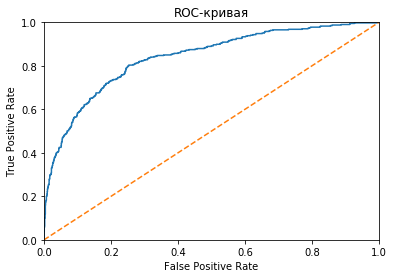

In [49]:
probabilities_test = best_ohe_forest_model.predict_proba(ohe_features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(ohe_target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [50]:
roc_auc_score(ohe_target_test, probabilities_one_test)

0.8390701950023984

Показатель roc_auc высок.

# Вывод

Качество модели удалось повысить благодаря борьбе с дисбалансом классов целевого признака.

Эффективным способом борьбы с дисбалансом оказалось увеличение выборки за счет дублирования объектов с положительным значением целевого признака.

В финальной модели показатель f1 на тестовом наборе данных превысил значение 0.59, а показатель roc-auc - 0.839.  